**По датасетам**

Нашел, какими датасетами можно воспользоваться: вначале расскажу, как у нас набираются ханипоты (контрольные задания для проверки качества разметки толокерами)
* Толокерам даются боевые задания, которые они размечают (обычная разметка, за которую мы им платим)
* Из того, что разметили толокеры, с определенной периодичностью(неделя или месяц) берется семпл заданий(например, 500 заданий) и они размечаются ассесорами(наши доверенные разметчики, которые у нас работают в штате и мы считаем, что их качество можно считать ground truth)
* Далее размеченные задания добавляются в общий пул ханипотов и в дальнейших пулах на этих ханипотах уже оценивает качество разметки толокеров
Я нашел два проекта(разметки), которые нам могут подходить в качестве датасетов:
1. **Разметка картинок на визуальное качество(для картинок)**
* Разметка предполагает, что толокеру дается картинка и его задача сказать, какого она качества (хорошего, среднего или плохого). Выглядит это так:
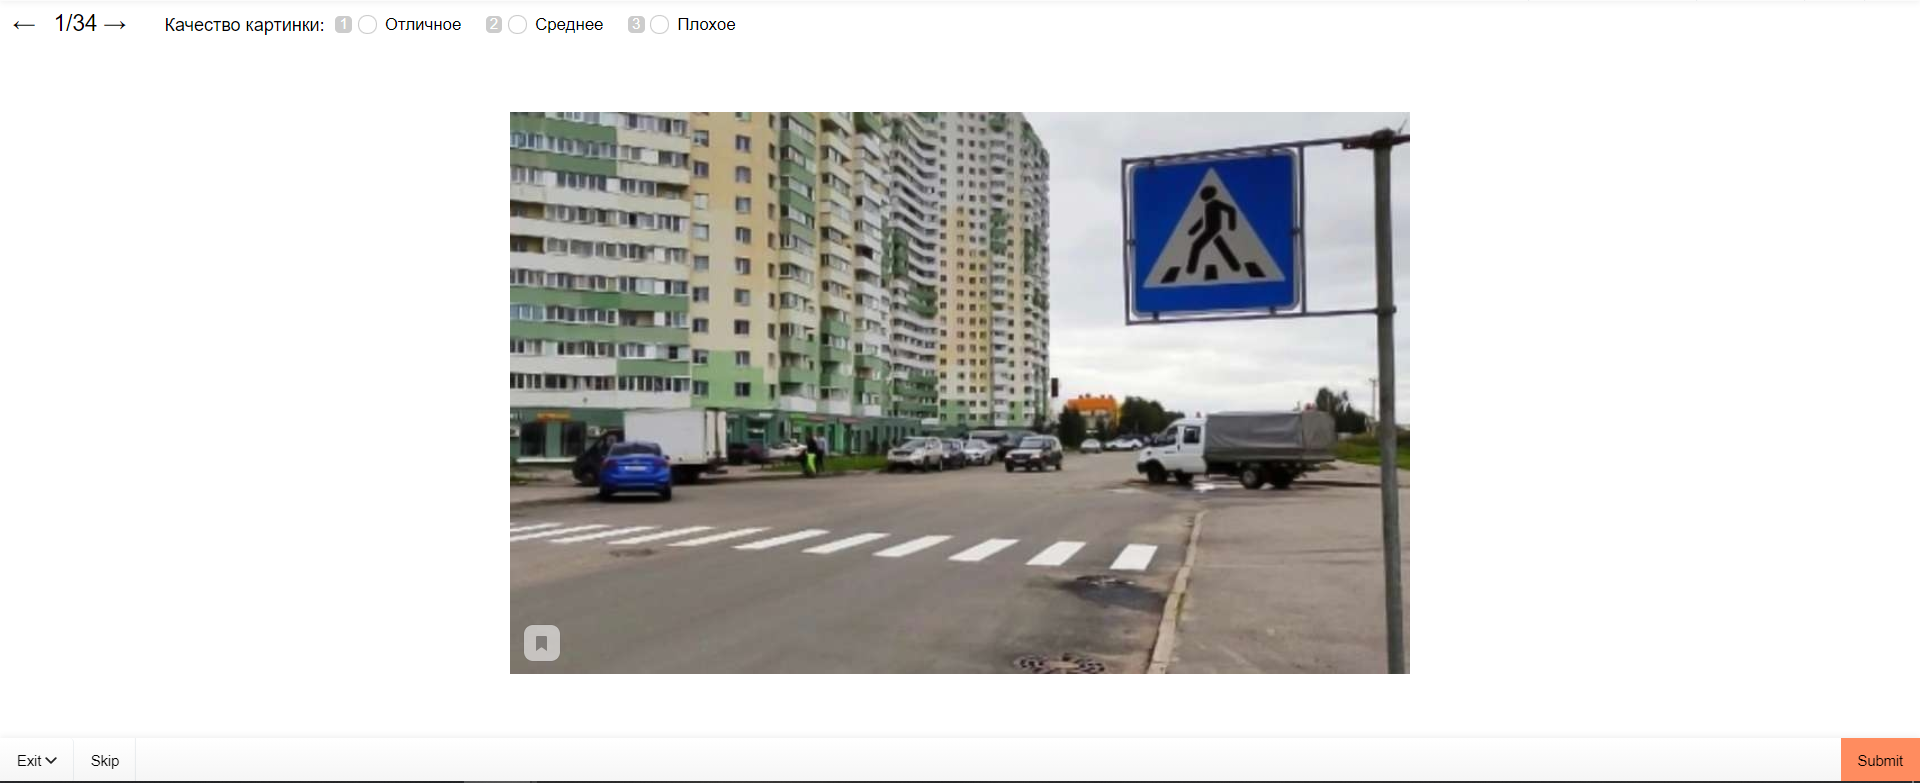
* В хранилище находится около **64 160** ханипотов. Их распределение **(GOOD-OK-BAD: 37%-31%-32%)**, немного смещенное.
* Но не по всем ханипотам подтянулась история в лице толокерских ответов: она есть только у **28 954** ханипотов. По ним идеальное распределение **(GOOD-OK-BAD: 34%-32%-33%)**. То, что не подтянулись ответы толокеров довольно странно, я это спрашивать буду в понедельник, возможно раньше был какой то другой процесс сбора ханипотов, но даже так, мы можем использовать ханипоты по которым не подтянулась история, например как в статье или random_flip. Неподтянушвихся ханипотов **35 206**. По не подтянувшимся ханипотам следующее распределение: **(GOOD-OK-BAD: 39%-30%-31%)**
* Возможно нужно будет срезать из ханипотов, к которым подтянулась история около 3к строк, у них почему то только один ответ толокера подтянулся, что странно
* я оценил "шумность" датасета двумя способами:
  * сравнил ответ ассесора(ground_truth) и случайный ответ толокера из истории: получилась **77.6% совпадений**
  * сравнил ответ ассесора(ground_truth) и агрегированный ответ толокера(из истории выбрал самый частый): получилась **85.4% совпадений**
* впринципе я доволен такими результатами, это нижняя и верхняя оценка шумности датасета, дальше мы можем пробовать другие способы агрегации истории толокеров, если захотим выше или ниже уровень шумности датасета
* **суммируя вышенаписанное, мне нравится этот датасет и я бы хотел его использовать: задача простая, датасет большой + недавно к нам приходила смежная группа, они рассказывали, что они экспериментировали с этим проектом, используя резнет, чтобы увеличить точность ответов толокеров, возможно я смогу переиспользовать их наработки.**

2. **Разметка Связаны ли запросы или нет(для текста)**
* Разметка предполагает, что толокеру дается два запроса и его задача, чтобы он сказал, как эти два запроса соотносятся. Выглядит это так:
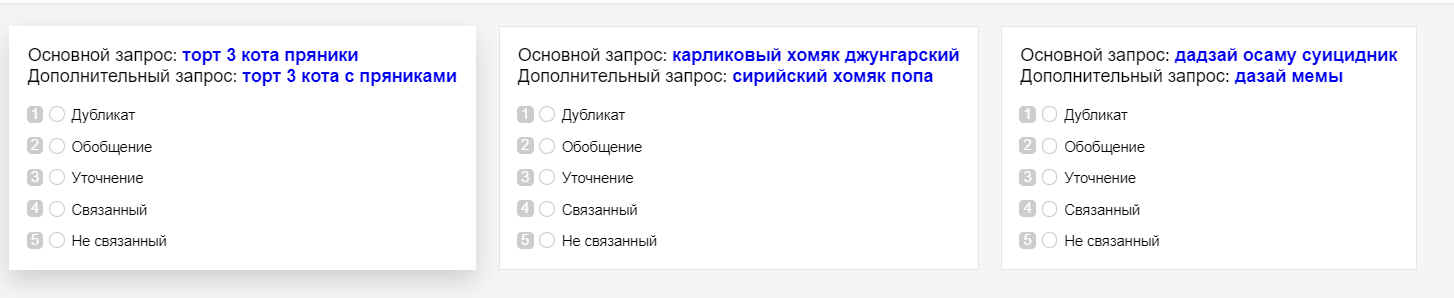
* В хранилище находится около **3 363** ханипотов. Их распределение **(уточнение-связанные-обобщение-дубли-несвязанные запросы: 53%-5%-5%-23%-4%)**, какое то ужасное распределение но возможно мы это можем использовать как пример несбалансированного датасета + я думал может стоит смерджить какие то классы, например (обобщение, уточнение и связанные) в один класс, в таком случае будет три класса.
* я оценил "шумность" датасета двумя способами:
  * сравнил ответ ассесора(ground_truth) и случайный ответ толокера из истории: получилась **77.1% совпадений**
  * сравнил ответ ассесора(ground_truth) и агрегированный ответ толокера(из истории выбрал самый частый): получилась **90.4% совпадений**
* точность даже выше чем у картиночной разметки, что очень странно, может где то ошибся.
* **по этой разметке у меня сомнения, она небольшая, всего 3к запросов, плюс перекос классов, но проблема в том, что я у нас не нашел какую-либо другую текстовую разметку, мы обычно не размечаем чисто текстовые задачи, обычно это связка картинка + запрос, поэтому здесь я 70% за использование этого датасета, 30% против.**

In [45]:
from nile.api.v1 import (
    clusters,
    aggregators as na
)

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sns.set()
pd.set_option('display.min_rows', 50)
cluster = clusters.Hahn()

In [46]:
def add_annotations(title, xlabel, ylabel, legend=True):
    if legend:
        plt.legend()
    plt.xlabel(title)
    plt.ylabel(xlabel)
    plt.title(ylabel)

# 0. Загрузка таблиц

In [53]:
path = '//home/images/dev/spochukaev/hse_diploma/image_classification'
image_class = cluster.read(path).as_dataframe()

path = '//home/images/dev/spochukaev/hse_diploma/image_classification_all_honeypots'
image_all = cluster.read(path).as_dataframe()

path = '//home/images/dev/spochukaev/hse_diploma/text_classification'
text_class = cluster.read(path).as_dataframe()

path = '//home/images/dev/spochukaev/hse_diploma/text_classification_all_honeypots'
text_all = cluster.read(path).as_dataframe()

In [54]:
# при выгрузке колонки с текстом выгружаются в binary формате
image_class['aggr_answer'] = image_class['aggr_answer'].str.decode('utf8')
image_class['assessors_answer'] = image_class['assessors_answer'].str.decode('utf8')
image_class['some_answer'] = image_class['some_answer'].str.decode('utf8')
image_class['query'] = image_class['query'].str.decode('utf8')
image_class['least_common'] = image_class['least_common'].str.decode('utf8')

text_class['aggr_answer'] = text_class['aggr_answer'].str.decode('utf8')
text_class['assessors_answer'] = text_class['assessors_answer'].str.decode('utf8')
text_class['some_answer'] = text_class['some_answer'].str.decode('utf8')
text_class['query'] = text_class['query'].str.decode('utf8')
text_class['related_query'] = text_class['related_query'].str.decode('utf8')
text_class['least_common'] = text_class['least_common'].str.decode('utf8')

image_all['assessors_answer'] = image_all['assessors_answer'].str.decode('utf8')
image_all['query'] = image_all['query'].str.decode('utf8')

text_all['assessors_answer'] = text_all['assessors_answer'].str.decode('utf8')
text_all['query'] = text_all['query'].str.decode('utf8')
text_all['related_query'] = text_all['related_query'].str.decode('utf8')

In [55]:
# первые 5 строк каждой таблицы
# query - урл страницы где хранится картинка
# assesors_answer - ответ, который дал ассесор
image_all.head(5)

,assessors_answer,query
0,BAD,http://storage.mds.yandex.net:80/get-mimcache/...
1,GOOD,http://storage.mds.yandex.net:80/get-mimcache/...
2,OK,http://storage.mds.yandex.net:80/get-mimcache/...
3,OK,http://storage.mds.yandex.net:80/get-mimcache/...
4,GOOD,http://storage.mds.yandex.net:80/get-mimcache/...


In [56]:
# первые 5 строк каждой таблицы
# query - запрос пользователя
# related_query - связанный запрос пользователя
# assesors_answer - ответ, который дал ассесор
text_all.head(5)

,assessors_answer,query,related_query
0,DUPS,этот неловкий момент фильм 2015,Этот неловкий момент 2015
1,REF,константин васильев картины,Картина Васильева человек с филином
2,DUPS,huawwei p20 lite,Хуавей р20 Лайт
3,REF,надпись юля,Надпись Юля на прозрачном фоне
4,REL,люди икс: тёмный феникс фильм 2019,Джин грей Софи Тернер


In [57]:
# первые 5 строк каждой таблицы
# query - урл страницы где хранится картинка
# assesors_answer - ответ, который дал ассесор
# cnt - количество оценок толокеров(это своего рода размер истории ответов толокеров на этот ханипот, то есть сколько у меня есть ответов толокеров на этот ханипот)
# some_answer - случайная оценка толокера из истории ханипота
# aggr_answer - агрегированная оценка ханипота(самая частая оценка в истории)
image_class.head(5)

,aggr_answer,assessors_answer,cnt,least_common,query,some_answer
0,BAD,BAD,15,OK,http://storage.mds.yandex.net:80/get-mimcache/...,BAD
1,BAD,BAD,2,BAD,http://storage.mds.yandex.net:80/get-mimcache/...,BAD
2,BAD,BAD,6,BAD,http://storage.mds.yandex.net:80/get-mimcache/...,BAD
3,BAD,BAD,11,BAD,http://storage.mds.yandex.net:80/get-mimcache/...,BAD
4,BAD,BAD,10,OK,http://storage.mds.yandex.net:80/get-mimcache/...,OK


In [58]:
# первые 5 строк каждой таблицы
# query - запрос пользователя
# related_query - связанный запрос пользователя
# assesors_answer - ответ, который дал ассесор
# cnt - количество оценок толокеров(это своего рода размер истории ответов толокеров на этот ханипот, то есть сколько у меня есть ответов толокеров на этот ханипот)
# some_answer - случайная оценка толокера из истории ханипота
# aggr_answer - агрегированная оценка ханипота(самая частая оценка в истории)
text_class.head(5)

,aggr_answer,assessors_answer,cnt,least_common,query,related_query,some_answer
0,DUPS,DUPS,30,REL,"""девять ярдов""",Девять ярдов the whole Nine Yards (2000),DUPS
1,DUPS,DUPS,30,REF,100 долларов,100 Долларовая купюра,DUPS
2,DUPS,DUPS,30,REF,2 3 4 player games,Игра на двоих на троих на четверых,DUPS
3,DUPS,DUPS,25,DUPS,200 рубл,200 Рублей,DUPS
4,DUPS,DUPS,30,REL,2019-yili nomlanishi,2019 Йил номланиши,DUPS


# 1. Анализ таблиц

## 1.1 Картиночная разметка

#### вначале смотрим все ханипоты по картиночной разметке

Кол-во ханипотов в базе 64160
Кол-во строк в таблице 64160
Распределение ответов в ханипотах
                     query
assessors_answer          
BAD               0.319373
GOOD              0.312188
OK                0.368438


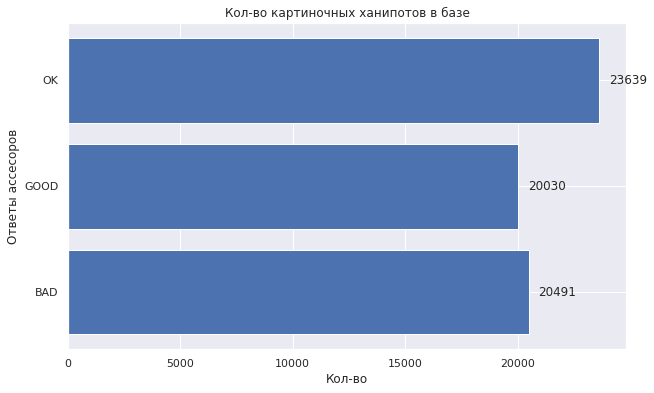

In [59]:
sns.set(rc={'figure.figsize':(10,6)})
def query_info(df, title, column):
    print('Кол-во ханипотов в базе', len(df['query'].unique()))
    print('Кол-во строк в таблице', len(df['query']))
    print('Распределение ответов в ханипотах')
    hbars = df.groupby(column).count().reset_index()
    print(df.groupby(column).count()/df.groupby(column).count().sum())
    fig, ax = plt.subplots()
    ax.barh(hbars['assessors_answer'], hbars['query'])
    add_annotations('Кол-во', 'Ответы ассесоров', title, False)
    ax.bar_label(ax.containers[0], padding=10)

query_info(image_all, 'Кол-во картиночных ханипотов в базе', 'assessors_answer')

Распределение ханипотов по лейблам примерно одинаковое (GOOD-OK-BAD: 37%-31%-32%). Чекнул что все ханипоты уникальны.

#### теперь смотрим подтянувшиеся оценки толокеров

In [60]:
print('Кол-во подтянувшихся уникальных ханипотов', len(image_class['query'].unique()))

Кол-во подтянувшихся уникальных ханипотов 28954


In [61]:
diff = np.setdiff1d(image_all['query'].unique(), image_class['query'].unique(), assume_unique=True)

In [62]:
# чекнул у себя, может баг, что половина ханипотов не подтянулась, 
# но действительно не находятся ответы толокеров по ханипотам, не знаю с чем это связано, возможно раньше логика сбора ханипотов была другая, спрошу в понедельник у своих 
diff[0]

'http://storage.mds.yandex.net:80/get-mimcache/4479255/6d6fd71075d9bec653378a6446800364'

In [63]:
print('Кол-во ханипотов без оценки:', len(diff))

Кол-во ханипотов без оценки: 35206


Кол-во ханипотов в базе 28954
Кол-во строк в таблице 28954
Распределение ответов в ханипотах
                  aggr_answer       cnt  least_common     query  some_answer
assessors_answer                                                            
BAD                  0.329143  0.329143      0.329143  0.329143     0.329143
GOOD                 0.331975  0.331975      0.331975  0.331975     0.331975
OK                   0.338882  0.338882      0.338882  0.338882     0.338882


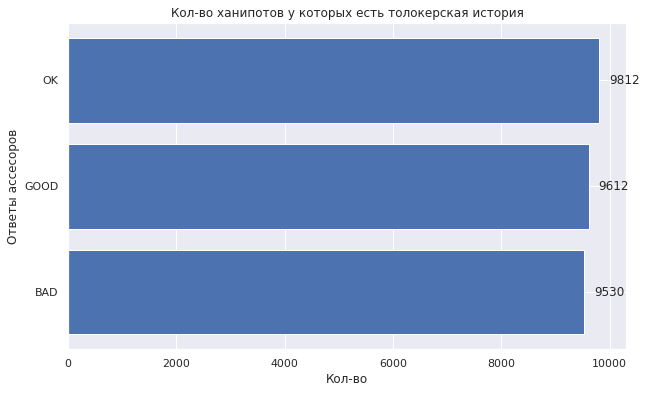

In [64]:
query_info(image_class, 'Кол-во ханипотов у которых есть толокерская история', 'assessors_answer')

Кол-во ханипотов в базе 35206
Кол-во строк в таблице 35206
Распределение ответов в ханипотах
                     query
assessors_answer          
BAD               0.311339
GOOD              0.295915
OK                0.392746


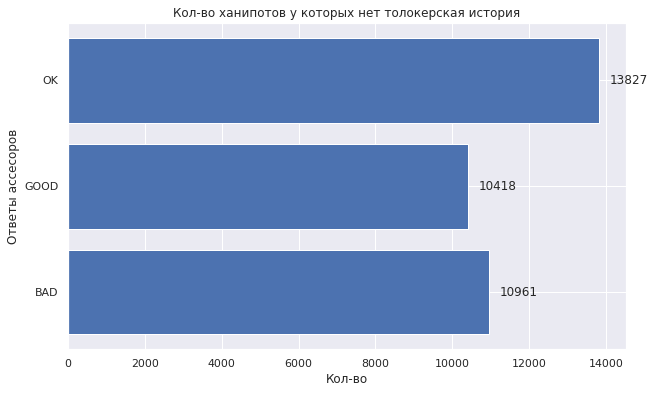

In [65]:
query_info(image_all[image_all['query'].isin(diff)], 'Кол-во ханипотов у которых нет толокерская история', 'assessors_answer')

В ханипотах с толокерской историей также нет перекосов в один из классов(GOOD-OK-BAD: 34%-32%-33%), 
в ханипотах без истории есть перекос в класс "ОК", но вроде некритичный (GOOD-OK-BAD: 39%-30%-31%)


#### еще сделаю мини-чек, распределение кол-ва размера истории у ханипотов

Ханипот с наибольшой историей 1044
Ханипот с наименьшей историей 1
Квантиль, чтобы хистограмма адекватно отрисовалась 13.0
Ханипот с одной оценкой 2867


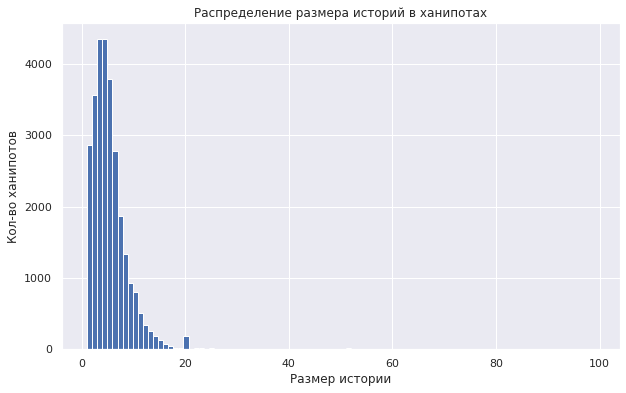

In [66]:
print('Ханипот с наибольшой историей', image_class['cnt'].max())
print('Ханипот с наименьшей историей', image_class['cnt'].min())
print('Квантиль, чтобы хистограмма адекватно отрисовалась', image_class['cnt'].quantile(0.95))
print('Ханипот с одной оценкой', image_class[image_class['cnt'] == 1].shape[0])

fig, ax = plt.subplots()
image_class[image_class['cnt'] < 100]['cnt'].hist(bins=100)
add_annotations('Размер истории', 'Кол-во ханипотов', 'Распределение размера историй в ханипотах', False)

Немного странные результаты, возможно стоит выкинуть ханипоты с историей равно 1 или больше 13, не могу пока сформулировать почему, просто это очень странно.

#### теперь смотрим насколько разметка "шумная" (насколько сходятся ответы толокеров и ассесоров)

In [67]:
image_class['accuracy_on_some_answer'] = image_class['some_answer'] == image_class['assessors_answer']
image_class['accuracy_on_aggr_answer'] = image_class['aggr_answer'] == image_class['assessors_answer']
image_class['accuracy_on_least_answer'] = image_class['least_common'] == image_class['assessors_answer']

In [68]:
print('Точность на наименее вероятных ответах толокеров', image_class['accuracy_on_least_answer'].mean())
print('Точность на случайных ответах толокеров', image_class['accuracy_on_some_answer'].mean())
print('Точность на агрегированных ответах толокеров', image_class['accuracy_on_aggr_answer'].mean())

Точность на наименее вероятных ответах толокеров 0.5373005456931684
Точность на случайных ответах толокеров 0.7779581404987221
Точность на агрегированных ответах толокеров 0.8549077847620363


Думаю хорошие результаты, с которыми можно работать.

## 1.1 Текстовая разметка

#### вначале смотрим все ханипоты по картиночной разметке

In [69]:
# в хранилище есть дубликаты
text_all.drop_duplicates(inplace=True)
text_all['key'] = text_all['query'] + text_all['related_query']

Кол-во ханипотов в базе 3363
Кол-во строк в таблице 3363
Распределение ответов в ханипотах
                     query  related_query       key
assessors_answer                                   
DUPS              0.229854       0.229854  0.229854
GEN               0.047874       0.047874  0.047874
REF               0.537615       0.537615  0.537615
REL               0.140648       0.140648  0.140648
UNREL             0.044008       0.044008  0.044008


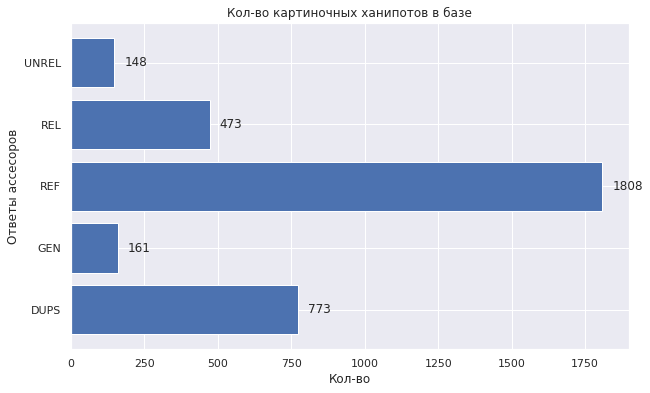

In [70]:
# unrel - несвязанные запросы
# gen - второй запрос является обобщением второго 
# ref - один запрос уточняет другой
# rel - запросы связаны
# dups - запросы дубли

sns.set(rc={'figure.figsize':(10,6)})
def query_info(df, title, column):
    print('Кол-во ханипотов в базе', len((df['key']).unique()))
    print('Кол-во строк в таблице', len(df['query']))
    print('Распределение ответов в ханипотах')
    hbars = df.groupby(column).count().reset_index()
    print(df.groupby(column).count()/df.groupby(column).count().sum())
    fig, ax = plt.subplots()
    ax.barh(hbars['assessors_answer'], hbars['query'])
    add_annotations('Кол-во', 'Ответы ассесоров', title, False)
    ax.bar_label(ax.containers[0], padding=10)

query_info(text_all, 'Кол-во картиночных ханипотов в базе', 'assessors_answer')

Распределение ханипотов по лейблам плохое (REL-REF-GEN-DUPS-UNREL: 53%-5%-5%-23%-4%)

#### теперь смотрим подтянувшиеся оценки толокеров

In [71]:
text_class['key'] = text_class['query'] + text_class['related_query']

In [72]:
print('Кол-во подтянувшихся уникальных ханипотов', len(text_class['key'].unique()))

Кол-во подтянувшихся уникальных ханипотов 3363


In [73]:
diff = np.setdiff1d(text_all['query'].unique(), text_class['query'].unique(), assume_unique=True)

In [74]:
# а тут наоборот подтянулись все оценки, но это разные проекты, с картинками один из основных наших проектов у которого огромная история, а текстовая разметка вспомогательная.
diff

array([], dtype=object)

In [75]:
print('Кол-во ханипотов без оценки:', len(diff))

Кол-во ханипотов без оценки: 0


Кол-во ханипотов в базе 3363
Кол-во строк в таблице 3363
Распределение ответов в ханипотах
                  aggr_answer       cnt  least_common     query  \
assessors_answer                                                  
DUPS                 0.229854  0.229854      0.229854  0.229854   
GEN                  0.047874  0.047874      0.047874  0.047874   
REF                  0.537615  0.537615      0.537615  0.537615   
REL                  0.140648  0.140648      0.140648  0.140648   
UNREL                0.044008  0.044008      0.044008  0.044008   

                  related_query  some_answer       key  
assessors_answer                                        
DUPS                   0.229854     0.229854  0.229854  
GEN                    0.047874     0.047874  0.047874  
REF                    0.537615     0.537615  0.537615  
REL                    0.140648     0.140648  0.140648  
UNREL                  0.044008     0.044008  0.044008  


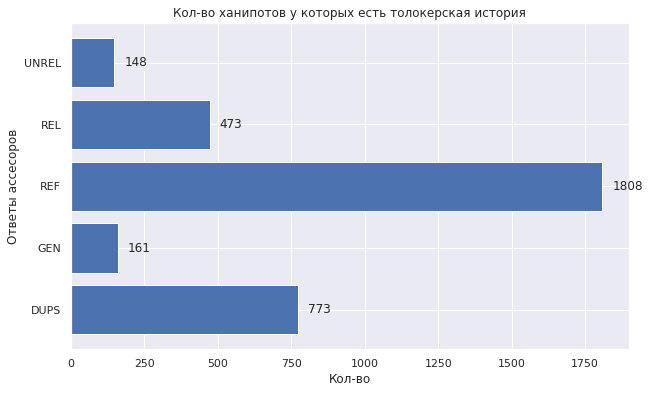

In [76]:
query_info(text_class, 'Кол-во ханипотов у которых есть толокерская история', 'assessors_answer')

Так как все ханипоты подтянулись, то имеем аналогичное распределение. (REF-REL-GEN-DUPS-UNREL: 53%-5%-5%-23%-4%)


In [77]:
text_class.groupby('assessors_answer')['cnt'].sum().reset_index()

,assessors_answer,cnt
0,DUPS,196802
1,GEN,153326
2,REF,192536
3,REL,133857
4,UNREL,163524


[Text(10, 0, '0.234276'),
 Text(10, 0, '0.182521'),
 Text(10, 0, '0.229197'),
 Text(10, 0, '0.159345'),
 Text(10, 0, '0.194661')]

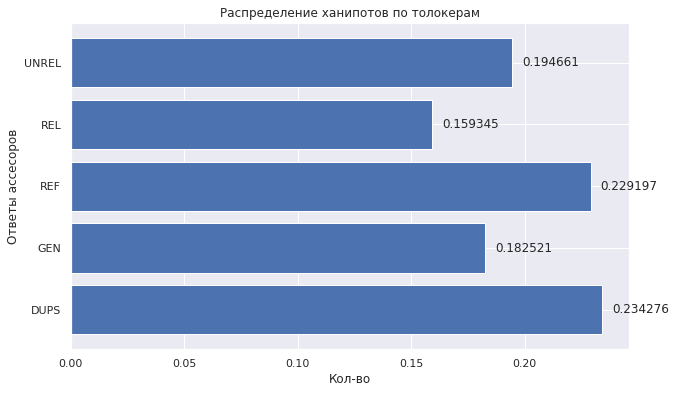

In [78]:
hbars = (text_class.groupby('assessors_answer')['cnt'].sum()/text_class.groupby('assessors_answer')['cnt'].sum().sum()).reset_index()
fig, ax = plt.subplots()
ax.barh(hbars['assessors_answer'], hbars['cnt'])
add_annotations('Кол-во', 'Ответы ассесоров', 'Распределение ханипотов по толокерам', False)
ax.bar_label(ax.containers[0], padding=10)

Распределение ответов ассесоров меня чуть больше успокаивает, ответы толокеров должны быть распределены примерно по 20%.

#### еще сделаю мини-чек, распределение кол-ва размера истории у ханипотов

Ханипот с наибольшой историей 21552
Ханипот с наименьшей историей 5
Квантиль, чтобы хистограмма адекватно отрисовалась 115.0
Ханипот с одной оценкой 0


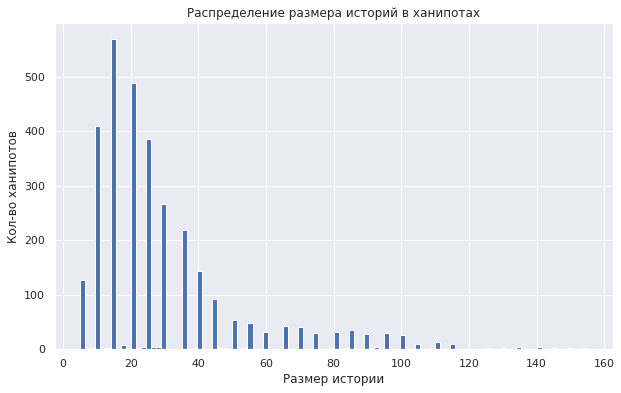

In [79]:
print('Ханипот с наибольшой историей', text_class['cnt'].max())
print('Ханипот с наименьшей историей', text_class['cnt'].min())
print('Квантиль, чтобы хистограмма адекватно отрисовалась', text_class['cnt'].quantile(0.95))
print('Ханипот с одной оценкой', text_class[text_class['cnt'] == 1].shape[0])

fig, ax = plt.subplots()
text_class[text_class['cnt'] < 160]['cnt'].hist(bins=100)
add_annotations('Размер истории', 'Кол-во ханипотов', 'Распределение размера историй в ханипотах', False)

Тут ханипотов не так много, поэтому история больше.

#### теперь смотрим насколько разметка "шумная" (насколько сходятся ответы толокеров и ассесоров)

In [82]:
text_class['accuracy_on_some_answer'] = text_class['some_answer'] == text_class['assessors_answer']
text_class['accuracy_on_aggr_answer'] = text_class['aggr_answer'] == text_class['assessors_answer']
text_class['accuracy_on_least_answer'] = text_class['least_common'] == text_class['assessors_answer']

In [83]:
print('Точность на наименее вероятных ответах толокеров', text_class['accuracy_on_least_answer'].mean())
print('Точность на случайных ответах толокеров', text_class['accuracy_on_some_answer'].mean())
print('Точность на случайных ответах толокеров', text_class['accuracy_on_aggr_answer'].mean())

Точность на наименее вероятных ответах толокеров 0.1977401129943503
Точность на случайных ответах толокеров 0.7853107344632768
Точность на случайных ответах толокеров 0.9066309842402617


Подозрительно высокая точность